In [ ]:
import sys

sys.path.append(r"../src")

from datasets.HMNIST import HealingMNIST

import os
import numpy as np
import matplotlib.pyplot as plt

os.chdir(r"../")
os.getcwd()

In [ ]:
data = np.load(r"C:\Developments\New folder\VAEImputer\data\SPRITES\sprites.npz")

In [ ]:
data.files

In [ ]:
# 12,288

x_full = data['x_train_full'].reshape(-1, 64, 64, 3)
x_miss = data['x_train_miss'].reshape(-1, 64, 64, 3)
x_mask = data['m_train_miss'].reshape(-1, 64, 64, 3)

x_mask_b = x_mask == 0

In [ ]:
plt.imshow(x_full[0])

In [ ]:
plt.imshow(x_miss[0])

In [ ]:
plt.imshow(x_full[0] * x_mask_b[0])

In [1]:
import os

import pytorch_lightning as pl
import numpy as np
import requests
import torch

from tqdm import tqdm
from torch import tensor
from torch.utils.data import DataLoader, TensorDataset

from hydra.utils import to_absolute_path

from typing import Optional


# https://github.com/NikitaChizhov/deep_kalman_filter_for_BM


class Spirits(pl.LightningDataModule):

    def __init__(self, download_dir, batch_size, num_workers, download_url, file_name):
        super().__init__()
        self.save_hyperparameters(logger=False)
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

    def prepare_data(self):
        if not os.path.exists(to_absolute_path(self.hparams.download_dir)):
            os.makedirs(to_absolute_path(self.hparams.download_dir))
        file_path = os.path.join(to_absolute_path(self.hparams.download_dir), self.hparams.file_name)
        if not os.path.exists(file_path):
            headers = {'user-agent': 'Wget/1.16 (linux-gnu)'}
            response = requests.get(self.hparams.download_url, stream=True, headers=headers)
            content_length = int(response.headers['Content-Length'])
            pbar = tqdm(total=content_length)
            with open(file_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=20_000_000):
                    if chunk:
                        f.write(chunk)
                    pbar.update(len(chunk))

    def setup(self, stage: Optional[str] = None):
        file_path = os.path.join(to_absolute_path(self.hparams.download_dir), self.hparams.file_name)
        data = np.load(file_path)

        image_shape = (-1, 8, 12288)

        # full data
        train_tensors = [tensor(data['x_train_full']).reshape(image_shape)]
        test_tensors = [tensor(data['x_test_full']).reshape(image_shape)]

        # missing and mask, 1 is an evidence for missing data

        train_tensors += [tensor(data['x_train_miss']).reshape(image_shape),
                          (tensor(data['m_train_miss']) == 0).reshape(image_shape)]
        test_tensors += [tensor(data['x_test_miss']).reshape(image_shape),
                         (tensor(data['m_test_miss']) == 0).reshape(image_shape)]

        self.train_dataset = TensorDataset(*train_tensors)
        self.test_dataset = TensorDataset(*test_tensors)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.hparams.batch_size, num_workers=self.hparams.num_workers,
                          persistent_workers=True, shuffle=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.hparams.batch_size, num_workers=self.hparams.num_workers,
                          persistent_workers=True)



In [2]:
import torch
import torch.nn as nn

class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.reshape(self.shape)


class Transpose(nn.Module):
    def __init__(self, perm):
        super(Transpose, self).__init__()
        self.perm = perm

    def forward(self, x):
        return x.permute(self.perm)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import MultivariateNormal, Normal
import pytorch_lightning as pl


class VAE(pl.LightningModule):

    def __init__(self, is_full=True):
        super().__init__()

        self.encoder = nn.Sequential(
            Reshape((-1, 64, 64, 3)),
            Transpose((0, 3, 1, 2)),
            nn.Conv2d(in_channels=3, out_channels=256, kernel_size=(3, 3), padding=1, dtype=torch.float32),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=3, kernel_size=(3, 3), padding=1, dtype=torch.float32),
            nn.ReLU(),
            Transpose((0, 2, 3, 1)),
            Reshape((-1, 8, 12288)),
            nn.Linear(in_features=12288, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=512),
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=256, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=12288)
        )

        # prior
        self.p_z = MultivariateNormal(loc=torch.zeros(256, device='cuda'),
                                      scale_tril=torch.diag(torch.ones(256, device='cuda')))
        self.beta = 0.8
        self.is_full = is_full

    def forward(self, x):
        statistics = self.encoder(x)
        mu, log_var = statistics[..., :256], statistics[..., 256:]
        std = F.softplus(log_var)
        q_z = MultivariateNormal(loc=mu, scale_tril=torch.diag_embed(std))
        z = q_z.rsample()
        x_hat = self.decoder(z)
        px_z = Normal(loc=x_hat, scale=torch.ones(x_hat.shape, device=x_hat.device))

        return q_z, px_z, x_hat

    def step(self, x):
        # q_z, x_hat = self.forward(x)
        # kl_loss = torch.distributions.kl.kl_divergence(q_z, self.p_z)
        # reconstruction_error = F.mse_loss(target=x.reshape(-1, 12288), input=x_hat, reduction='none').sum(1)
        # loss = reconstruction_error + self.beta * kl_loss
        # return loss.mean(), x_hat

        q_z, px_z, x_hat = self.forward(x)

        log_likelihood = px_z.log_prob(x)
        log_likelihood_per_series = log_likelihood.sum([1, 2])
        
        kl = torch.distributions.kl.kl_divergence(q_z, self.p_z)
        kl = kl.sum(1)

        elbo = log_likelihood_per_series - self.beta * kl
        elbo = elbo.mean()
        loss = -elbo

        return loss.mean(), x_hat

    def training_step(self, batch, batch_idx):
        x_full, x_miss, x_mask = batch
        x = x_full if self.is_full else x_miss

        loss, x_hat = self.step(x)

        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def predict_step(self, batch, batch_idx):
        x_full, x_miss, x_mask = batch
        x = x_full if self.is_full else x_miss

        loss, x_hat = self.step(x)

        return x_hat

    def configure_optimizers(self):
        return torch.optim.Adam(params=self.parameters(), lr=1e-3, weight_decay=0.05)

In [4]:
spirits_dataset = Spirits(download_dir="C:\\Developments\\New folder\\VAEImputer\\data\\SPRITES",
                              download_url="https://www.dropbox.com/s/1bdpmsmf7vu7pmb/sprites.npz?dl=1",
                              file_name="sprites.npz",
                              batch_size=64,
                              num_workers=4)

spirits_dataset.setup()


train_data = spirits_dataset.train_dataloader()
test_data = spirits_dataset.test_dataloader()

In [5]:
model = VAE(is_full=False)
trainer = pl.Trainer(gpus=1, max_epochs=5)
trainer.fit(model=model, train_dataloaders=train_data)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 613 K 
1 | decoder | Sequential | 3.4 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.874    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [6]:
import matplotlib.pyplot as plt

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\itama\anaconda3\envs\pytorch-trainer\lib\site-packages\pytorch_lightning\trainer\data_loading.py:655: UserWarning: Your `predict_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Predicting: 141it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


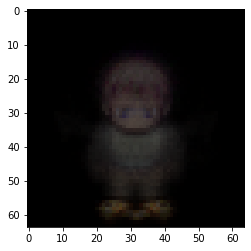

In [7]:
prediction = trainer.predict(model=model, dataloaders=train_data)
plt.imshow(prediction[0][0][0].reshape(64, 64, 3))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 141it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


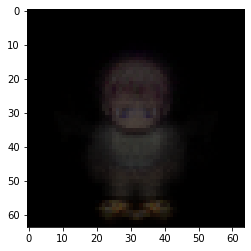

In [8]:
prediction = trainer.predict(model=model, dataloaders=test_data)
plt.imshow(prediction[0][0][0].reshape(64, 64, 3))